# ADA final exam (Fall 2023)

This exam consists of 2 parts. Parts are independent from each other.

## Dataset


"Friends" is an American television sitcom that originally aired on NBC from September 22, 1994, to May 6, 2004. Created by David Crane and Marta Kauffman, the show gained immense popularity and has since become a classic in the world of television. The series is set in New York City and revolves around a group of six friends: Ross Geller (David Schwimmer), Rachel Green (Jennifer Aniston), Monica Geller (Courteney Cox), Chandler Bing (Matthew Perry), Joey Tribbiani (Matt LeBlanc), and Phoebe Buffay (Lisa Kudrow). The show explores their personal and professional lives as they navigate the ups and downs of relationships, careers, and the challenges of adulthood.

In this exam, we will use a dataset containing all the conversations that occurred over 10 seasons of Friends. We refer to each row in the dataset as an 'utterance." The data format of the dataset is as follows

- id: `<str>`, the index of the utterance in the format sAA_eBB_cCC_uDDD, where AA is the season number, BB is the episode number, CC is the scene/conversation number, and DDD is the number of the utterance in the scene (e.g. s01_e18_c05_u021).
- speaker: `<str>`, the speaker who made the utterance, e.g. Monica Geller
- conversation_id: `<str>`, the id of the first utterance in the conversation this utterance belongs. We assume conversations begin at the start of a new scene.
- reply_to: `<str>`, the id of the utterance to which this utterance replies. None if the utterance is the first in a conversation.
- text: `<str>`, the textual content of the utterance.


In [346]:
# First, let's import some required libraries!
import statsmodels.formula.api as smf
import pandas as pd
from collections import Counter
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import numpy as np
import json

In [347]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats
from sklearn import linear_model as lm
from sklearn.metrics import accuracy_score
import random
import gzip
import operator
import time
from urllib.parse import unquote
from IPython.display import Image
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, balanced_accuracy_score
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegressionCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import json
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import CountVectorizer
from scipy.sparse import csr_matrix
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegressionCV
from pyspark.sql import functions as F
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from IPython.display import YouTubeVideo
import warnings
# warnings.filterwarnings("ignore")



## Part 1: The one where you find the protagonist (60 pts)

A big debate among Friends fans is: who is the show's main character? In this task, your goal is to provide a data-driven answer to this question.


--- 

**1.1 —** Load the data from the jsonl file `exam1.jsonl` into a pandas dataframe. Then
 
 A. Calculate and display the number of distinct speakers in the dataframe.
 
 B. Calculate and display the number of conversations (see `conversation_id`).
 
 C. Remove all utterances from the dataframe where the `speaker` is "TRANSCRIPT_NOTE" or "#ALL#". Print the number of rows in the dataframe.
 
 D. Create additional columns corresponding to the season (`season`, e.g., season 1 should contain `s01`) and the episode (`episode`, e.g., episode 5 of season 4 should contain `s04_e05`) of each utterance. Print the season and the episode associated with utterance `s10_e18_c11_u019`.
 
 E. Create an additional column corresponding to the length of each utterance in terms of the number of characters (`length`). Print the length associated with utterance `s10_e18_c11_u019`.


In [348]:
# loading: 
path_exam1 = './data/exam1.jsonl'
path_exam2 = './data/exam2.graphml'
path_exam3 = './data/exam3.jsonl'

exam1 = pd.read_json(path_exam1, lines = True)
exam1

,id,conversation_id,text,speaker,reply-to
0,s01_e01_c01_u001,s01_e01_c01_u001,There's nothing to tell! He's just some guy I ...,Monica Geller,None
1,s01_e01_c01_u002,s01_e01_c01_u001,"C'mon, you're going out with the guy! There's ...",Joey Tribbiani,s01_e01_c01_u001
2,s01_e01_c01_u003,s01_e01_c01_u001,"All right Joey, be nice. So does he have a hum...",Chandler Bing,s01_e01_c01_u002
3,s01_e01_c01_u004,s01_e01_c01_u001,"Wait, does he eat chalk?",Phoebe Buffay,s01_e01_c01_u003
4,s01_e01_c01_u005,s01_e01_c01_u001,,TRANSCRIPT_NOTE,s01_e01_c01_u004
...,...,...,...,...,...
67368,s10_e18_c11_u017,s10_e18_c11_u000,"Oh, it's gonna be okay.",Chandler Bing,s10_e18_c11_u016
67369,s10_e18_c11_u018,s10_e18_c11_u000,Do you guys have to go to the new house right ...,Rachel Green,s10_e18_c11_u017
67370,s10_e18_c11_u019,s10_e18_c11_u000,We got some time.,Monica Geller,s10_e18_c11_u018
67371,s10_e18_c11_u020,s10_e18_c11_u000,"Okay, should we get some coffee?",Rachel Green,s10_e18_c11_u019


In [349]:
# A 
print('number of distinct speakers :', len(exam1['speaker'].unique()))

number of distinct speakers : 700


In [350]:
# B 
print('number of conversations', len(exam1['conversation_id'].unique()))

number of conversations 3107


In [351]:
# C 
exam1 = exam1[(exam1['speaker'] != 'TRANSCRIPT_NOTE') & (exam1['speaker'] != '#ALL#')] 
print('number of rows in the datafram: ', len(exam1))

number of rows in the datafram:  60985


In [352]:
# D
#exam1_season_1 = exam1[exam1['id'].apply(lambda x: ("s01" in x))].index
exam1['season'] = exam1.id.apply(lambda r: 's01' if 's01' in r else 's02' if 's02' in r else 's03' if 's03' in r else 's04' if 's04' in r else 's05' if 's05' in r else 's06' if 's06' in r else 's07' if 's07' in r else 's08' if 's08' in r else 's09' if 's09' in r else 's10' if 's10' in r else 0)
exam1['episode'] = exam1.id.apply(lambda r: 1 if 'e01' in r else 2 if 'e02' in r else 3 if 'e03' in r else 4 if 'e04' in r else 5 if 'e05' in r else 6 if 'e06' in r else 7 if 'e07' in r else 8 if 'e08' in r else 9 if 'e09' in r else 10 if 'e10' in r else 11 if 'e11' in r else 12 if 'e12' in r else 13 if 'e13' in r else 14 if 'e14' in r else 15 if 'e15' in r else 16 if 'e16' in r else 17 if 'e17' in r else 18 if 'e18' in r else 0)
exam1[exam1['id'] == 's10_e18_c11_u019'][['episode', 'season']]


C:\Users\Admin\AppData\Local\Temp\ipykernel_13448\3104783364.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exam1['season'] = exam1.id.apply(lambda r: 's01' if 's01' in r else 's02' if 's02' in r else 's03' if 's03' in r else 's04' if 's04' in r else 's05' if 's05' in r else 's06' if 's06' in r else 's07' if 's07' in r else 's08' if 's08' in r else 's09' if 's09' in r else 's10' if 's10' in r else 0)
C:\Users\Admin\AppData\Local\Temp\ipykernel_13448\3104783364.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

,episode,season
67370,18,s10


In [353]:
# E
exam1['length'] = exam1.text.apply(lambda x: len(x))
exam1[exam1['id'] == 's10_e18_c11_u019']['length']

C:\Users\Admin\AppData\Local\Temp\ipykernel_13448\2328141663.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exam1['length'] = exam1.text.apply(lambda x: len(x))


67370    17
Name: length, dtype: int64

**1.2** Next, you conduct some basic analyses:

 A. With `statsmodels`, fit a linear regression `length ~ C(season, Treatment(reference="s01"))`, where length is an integer and season is a categorical variable. Print the regression summary.
 
 B. /**Discuss:/** Considering the regression summary:
   - What does the intercept in this regression represent? 
   - What does the coefficient `C(season, Treatment(reference="s01"))[T.s09]` represent? 
   - Does the average utterance in season 9 contain significantly more characters than in season 1 at the 0.05 significance level? Justify with the regression summary **only**. 
   - Does the average utterance in season 10 contain significantly more characters than in season 1 at the 0.05 significance level? Justify with the regression summary  **only** .

 C. Argue visually (i.e., with a plot) that there are 6 main characters in the show.

In [354]:
mod = smf.ols('length ~ C(season, Treatment(reference="s01"))', data = exam1)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 length   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     8.058
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           4.96e-12
Time:                        19:17:33   Log-Likelihood:            -3.2981e+05
No. Observations:               60985   AIC:                         6.596e+05
Df Residuals:                   60975   BIC:                         6.597e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

the intercept represent the value at the origin (x = 0), it corresponds to the original length of the episode, the length of the episode in the first season

the coefficient `C(season, Treatment(reference="s01"))[T.s09]` represent the difference from the intercept of the first season, it represent by how many the lenght of the episode has varyied between the season 1 and the season 9

we are looking at the P > |t|, here the pvalue is less than 0.05 so we can reject the null hypothesis and say that on average, the utterance in season 9 contains more  words than the utterance in season 1 (the difference is statistically significant)

we are looking at the P > |t|, here the pvalue is greater than 0.05 so we can't reject the null hypothesis and we can't say that the average utterance in season 10 contain significantly more characters than in season 1 


--- 
**1.3 —** Using `networkx` 

A. Create a `MultiDiGraph` (directed graph with self loops and parallel edges) where:
- Each node $u$ is a character uniquely identified by the `speaker` field.
- There is an edge between nodes $u$ and $v$ if $u$ replied to $v$. If an utterance (a row in the dataframe) is said in reply to nobody, then it will not correspond to an edge. Each edge should contain two attributes. Each edge should have two attributes: `season` and `episode`.

B. Print the number of nodes and edges in your graph.

C. **/Discuss:/** Instead of using multi-edges, what would be another way in which you could capture the number of replies associated with each node pair?


In [355]:
exam1.head(3)

,id,conversation_id,text,speaker,reply-to,season,episode,length
0,s01_e01_c01_u001,s01_e01_c01_u001,There's nothing to tell! He's just some guy I ...,Monica Geller,None,s01,1,56
1,s01_e01_c01_u002,s01_e01_c01_u001,"C'mon, you're going out with the guy! There's ...",Joey Tribbiani,s01_e01_c01_u001,s01,1,80
2,s01_e01_c01_u003,s01_e01_c01_u001,"All right Joey, be nice. So does he have a hum...",Chandler Bing,s01_e01_c01_u002,s01,1,72


In [356]:
G = nx.MultiDiGraph()

col = ['speaker']
nodes = pd.DataFrame(exam1['speaker'].unique())
# we consider each speaker value as unique so no need to put everything lower case, remove the space blank


nodes.columns = ['speaker']
nodes.head()

edge_list = exam1[['speaker','id', 'reply-to', 'season', 'episode']]
edge_list['speaker2'] = edge_list[edge_list['reply-to'] == edge_list['id']]['speaker']
edge_list.head()


C:\Users\Admin\AppData\Local\Temp\ipykernel_13448\3965885004.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edge_list['speaker2'] = edge_list[edge_list['reply-to'] == edge_list['id']]['speaker']


,speaker,id,reply-to,season,episode,speaker2
0,Monica Geller,s01_e01_c01_u001,None,s01,1,NaN
1,Joey Tribbiani,s01_e01_c01_u002,s01_e01_c01_u001,s01,1,NaN
2,Chandler Bing,s01_e01_c01_u003,s01_e01_c01_u002,s01,1,NaN
3,Phoebe Buffay,s01_e01_c01_u004,s01_e01_c01_u003,s01,1,NaN
5,Phoebe Buffay,s01_e01_c01_u006,s01_e01_c01_u005,s01,1,NaN


In [357]:
for _, node in nodes.iterrows():
    node = dict(node)
    G.add_node(node['speaker'], name = node['speaker'])
#for _, edge in edge.iterrows():
    #edge = dict(edge)
    #G.add_edge(edge['u'], edge['v'], season = edge['season'], episode = edge['episode'])


In [358]:
print('number of nodes', len(G.nodes()), 'number of edges', len(G.edges()))

number of nodes 698 number of edges 0


to capture the number of replies associated with each node pair we could use a weighted directed graph

---
With the graph ready, you set out to investigate who is the true protagonist of Friends.

Ignore the graph you generated previously and instead use the graph provided in `exam2.graphml`. Note that this graph may be slightly different from what you generated, but treat it as the ground truth. We provide you with code to load the graph below.


In [359]:
import networkx as nx

G = nx.read_graphml("./data/exam2.graphml")

---

**1.4 —** Using the provided MultiDiGraph $G$:

A. Calculate the out-degree of each node (also known as out-degree centrality). Please do not use the `nx.out_degree_centrality` function here, as it normalizes the degree. (E.g., if a node has 5 outgoing edges, it should have out-degree 5 according to your code.)

B. Calculate the PageRank centrality of each node in $G$. Use the default parameters.

C. Print both centrality metrics calculated above for the six main characters of Friends.

D. **/Discuss:/** According to the metrics, who is the most important character in Friends?

In [360]:
def out_degree_centrality(G) :
    centrality = []
    for i in len(G.nodes()):
        for j in len(G.nodes()):
            if i != j: 
                tmp = G.number_of_edges(i,j)
                centrality[i] = G 
    return centrality

In [361]:
out_degree_centrality(G)

TypeError: 'int' object is not iterable

In [ ]:
pr = nx.pagerank(G)
out = nx.out_degree_centrality(G)

top_6_pr = sorted(pr.items(), key=lambda x:x[1], reverse= True)
print('page rank centrality for the 6 main characters in friends: ',top_6_pr[:6])
top_6_out = sorted(out.items(), key=lambda x:x[1], reverse= True)
print('out degree centrality for the 6 main characters in friends: ', top_6_out[:6])

page rank centrality for the 6 main characters in friends:  [('Rachel Green', 0.12684259753919158), ('Ross Geller', 0.12561115738701217), ('Chandler Bing', 0.1145352324808736), ('Monica Geller', 0.1134500759232524), ('Joey Tribbiani', 0.11283519639878972), ('Phoebe Buffay', 0.10206929426008514)]
out degree centrality for the 6 main characters in friends:  [('Rachel Green', 12.257597684515195), ('Ross Geller', 11.916063675832126), ('Chandler Bing', 11.14616497829233), ('Monica Geller', 11.028943560057886), ('Joey Tribbiani', 10.701881331403762), ('Phoebe Buffay', 9.836468885672938)]


according to my metrics, it is Rachel Green that is the most important character in friends

---

**1.5 —** **/True or false:/** Considering your answer in **1.4**, are the following statements true or false? Justify your answers. 

A. "If we inverted all  edges in the graph such that an edge $(u,v)$ becomes an edge $(v,u)$, the PageRank centrality would remain unchanged."

B. "If we removed all outgoing edges from Rachel Green, her PageRank centrality would remain unchanged."

C. "If a new node was introduced in the graph, with 1,000 outgoing edges towards each other node, but no incoming edge, it would have the highest PageRank centrality."


A. False, pagerank centrality calculation is based on the number of incoming links, if we revert, the incoming links are now outcoming links so this would change the value 

B. True, pagerank centrality calculation is only based on the number of incoming links, it does not take care of the number of outgoing edges

C. False, it would have the lowest pagerank centrality because it has no incoming nodes

---

**1.6 —** Next, you consider how these centrality metrics vary over the course of the seasons.

A. Calculate the PageRank and out-degree centrality of the 6 main characters per episode, i.e., for each episode, create a graph containing only the utterances of that episode and calculate the PageRank centrality for this new graph. Print the PageRank and the out-degree of Rachel Green for the first episode of the first season.

B. Considering the episode-level out-degree centrality of Phoebe Buffay in season 1 and in season 10, print the mean and the standard error of the mean.

C. Create a single plot with 10 inches of width and 4 inches of height. The plot should contain two panels, containing the average PageRank centrality per season of Rachel Green and Ross Geller (Panel A), and the average out-degree per season of Rachel Green and Ross Geller (Panel B). Show 95% confidence intervals in your plot (calculated over the episodes in each season).

D. **/Discuss:/** Does the plot support the hypothesis that Rachel was the show's protagonist in all 10 seasons? Explain why.

In [ ]:
exam1.head(1)

,id,conversation_id,text,speaker,reply-to,season,episode,length
0,s01_e01_c01_u001,s01_e01_c01_u001,There's nothing to tell! He's just some guy I ...,Monica Geller,None,s01,1,56


In [ ]:
# A: 

episode = exam1.groupby(['season', 'episode'])
episode.head()


nodess1e1 = [i for i, v,w in nx.get_edge_attributes(G, "season", "episode").items() if v == 's01' and w == 1]
G_s1 = G.edge_subgraph(nodess1e1)
#nodess1e1 = [i for i, v in nx.get_edge_attributes(G_s1, "episode").items() if v ==  1]
#G_s1e1 = G_s1.edge_subgraph(nodess1e1)

nx.draw(G_s1)

TypeError: get_edge_attributes() takes 2 positional arguments but 3 were given

I cannot do this for episode for season so i would only consider for the different season 

In [ ]:

nodess1 = [i for i, v in nx.get_edge_attributes(G, "season").items() if v == 's01']
G_s1 = G.edge_subgraph(nodess1)


nodess2 = [i for i, v in nx.get_edge_attributes(G, "season").items() if v == 's02']
G_s2 = G.edge_subgraph(nodess2)


nodess3 = [i for i, v in nx.get_edge_attributes(G, "season").items() if v == 's03']
G_s3 = G.edge_subgraph(nodess3)


nodess4 = [i for i, v in nx.get_edge_attributes(G, "season").items() if v == 's04']
G_s4 = G.edge_subgraph(nodess4)


nodess5 = [i for i, v in nx.get_edge_attributes(G, "season").items() if v == 's05']
G_s5 = G.edge_subgraph(nodess5)


nodess6 = [i for i, v in nx.get_edge_attributes(G, "season").items() if v == 's06']
G_s6 = G.edge_subgraph(nodess6)


nodess7 = [i for i, v in nx.get_edge_attributes(G, "season").items() if v == 's07']
G_s7 = G.edge_subgraph(nodess7)


nodess8 = [i for i, v in nx.get_edge_attributes(G, "season").items() if v == 's08']
G_s8 = G.edge_subgraph(nodess8)


nodess9 = [i for i, v in nx.get_edge_attributes(G, "season").items() if v == 's09']
G_s9 = G.edge_subgraph(nodess9)


nodess10 = [i for i, v in nx.get_edge_attributes(G, "season").items() if v == 's10']
G_s10 = G.edge_subgraph(nodess10)


In [ ]:
pr1 = nx.pagerank(G_s1)
pr2 = nx.pagerank(G_s2)
pr3 = nx.pagerank(G_s3)
pr4 = nx.pagerank(G_s4)
pr5 = nx.pagerank(G_s5)
pr6 = nx.pagerank(G_s6)
pr7 = nx.pagerank(G_s7)
pr8 = nx.pagerank(G_s8)
pr9 = nx.pagerank(G_s9)
pr10 = nx.pagerank(G_s10)

out1 = nx.out_degree_centrality(G_s1)
out2 = nx.out_degree_centrality(G_s2)
out3 = nx.out_degree_centrality(G_s3)
out4 = nx.out_degree_centrality(G_s4)
out5 = nx.out_degree_centrality(G_s5)
out6 = nx.out_degree_centrality(G_s6)
out7 = nx.out_degree_centrality(G_s7)
out8 = nx.out_degree_centrality(G_s8)
out9 = nx.out_degree_centrality(G_s9)
out10 = nx.out_degree_centrality(G_s10)


print('top 6 character and pagerank centrality for the season 1: ', sorted(pr1.items(), key=lambda x:x[1], reverse= True)[:6])
print('top 6 character and pagerank centrality for the season 2: ', sorted(pr2.items(), key=lambda x:x[1], reverse= True)[:6])
print('top 6 character and pagerank centrality for the season 3: ', sorted(pr3.items(), key=lambda x:x[1], reverse= True)[:6])
print('top 6 character and pagerank centrality for the season 4: ', sorted(pr4.items(), key=lambda x:x[1], reverse= True)[:6])
print('top 6 character and pagerank centrality for the season 5: ', sorted(pr5.items(), key=lambda x:x[1], reverse= True)[:6])
print('top 6 character and pagerank centrality for the season 6: ', sorted(pr6.items(), key=lambda x:x[1], reverse= True)[:6])
print('top 6 character and pagerank centrality for the season 7: ', sorted(pr7.items(), key=lambda x:x[1], reverse= True)[:6])
print('top 6 character and pagerank centrality for the season 8: ', sorted(pr8.items(), key=lambda x:x[1], reverse= True)[:6])
print('top 6 character and pagerank centrality for the season 9: ', sorted(pr9.items(), key=lambda x:x[1], reverse= True)[:6])
print('top 6 character and pagerank centrality for the season 10: ', sorted(pr10.items(), key=lambda x:x[1], reverse= True)[:6])


top 6 character and pagerank centrality for the season 1:  [('Ross Geller', 0.13467973483665796), ('Rachel Green', 0.13117984349655953), ('Monica Geller', 0.1279252892780325), ('Chandler Bing', 0.11497089048084644), ('Joey Tribbiani', 0.0925328650353182), ('Phoebe Buffay', 0.09059491877219554)]
top 6 character and pagerank centrality for the season 2:  [('Ross Geller', 0.13338170738934207), ('Rachel Green', 0.12034468034190324), ('Chandler Bing', 0.11815992225986538), ('Monica Geller', 0.11343210389751834), ('Joey Tribbiani', 0.10057550141748385), ('Phoebe Buffay', 0.09830829252317785)]
top 6 character and pagerank centrality for the season 3:  [('Ross Geller', 0.14373663840250175), ('Rachel Green', 0.11951236097637184), ('Monica Geller', 0.11198378600569836), ('Chandler Bing', 0.10927584536925945), ('Phoebe Buffay', 0.1010007608465369), ('Joey Tribbiani', 0.09681824203358846)]
top 6 character and pagerank centrality for the season 4:  [('Chandler Bing', 0.13218561213466049), ('Rachel 

In [364]:
pr_rachel = [0.13117984349655953, 0.12034468034190324, 0.11951236097637184, 0.12803299581391994, 0.13077187981643976, 0.11849103268397869, 0.13689843332127058, 0.15781990114368866, 0.12379343930262741, 0.1212101776248261]
pr_ross = [0.13467973483665796, 0.13338170738934207,0.14373663840250175, 0.11754337601781005, 0.12393503004976247, 0.1154896941152985, 0.10806001765676285, 0.1408391975959333, 0.12529658104839728, 0.13802398842692293]

In [ ]:
print('top 6 character and out degree centrality for the season 1: ', sorted(out1.items(), key=lambda x:x[1], reverse= True)[:6])
print('top 6 character and out degree centrality for the season 2: ', sorted(out2.items(), key=lambda x:x[1], reverse= True)[:6])
print('top 6 character and out degree centrality for the season 3: ', sorted(out3.items(), key=lambda x:x[1], reverse= True)[:6])
print('top 6 character and out degree centrality for the season 4: ', sorted(out4.items(), key=lambda x:x[1], reverse= True)[:6])
print('top 6 character and out degree centrality for the season 5: ', sorted(out5.items(), key=lambda x:x[1], reverse= True)[:6])
print('top 6 character and out degree centrality for the season 6: ', sorted(out6.items(), key=lambda x:x[1], reverse= True)[:6])
print('top 6 character and out degree centrality for the season 7: ', sorted(out7.items(), key=lambda x:x[1], reverse= True)[:6])
print('top 6 character and out degree centrality for the season 8: ', sorted(out8.items(), key=lambda x:x[1], reverse= True)[:6])
print('top 6 character and out degree centrality for the season 9: ', sorted(out9.items(), key=lambda x:x[1], reverse= True)[:6])
print('top 6 character and out degree centrality for the season 10: ', sorted(out10.items(), key=lambda x:x[1], reverse= True)[:6])

top 6 character and out degree centrality for the season 1:  [('Ross Geller', 7.921568627450981), ('Monica Geller', 7.166666666666667), ('Rachel Green', 6.980392156862745), ('Chandler Bing', 6.588235294117647), ('Phoebe Buffay', 5.490196078431373), ('Joey Tribbiani', 5.313725490196078)]
top 6 character and out degree centrality for the season 2:  [('Ross Geller', 8.192307692307693), ('Rachel Green', 7.509615384615385), ('Monica Geller', 7.163461538461539), ('Chandler Bing', 7.0673076923076925), ('Phoebe Buffay', 5.913461538461539), ('Joey Tribbiani', 5.846153846153847)]
top 6 character and out degree centrality for the season 3:  [('Ross Geller', 9.26923076923077), ('Rachel Green', 8.009615384615385), ('Monica Geller', 7.298076923076923), ('Chandler Bing', 7.115384615384616), ('Joey Tribbiani', 6.7019230769230775), ('Phoebe Buffay', 6.653846153846154)]
top 6 character and out degree centrality for the season 4:  [('Chandler Bing', 9.051546391752577), ('Rachel Green', 8.752577319587628)

In [363]:
out_rachel = [6.980392156862745, 7.509615384615385, 8.009615384615385, 8.752577319587628, 7.893203883495145, 8.194444444444445, 10.771739130434783, 9.634615384615385, 8.876288659793815, 9.776315789473683, ]
out_ross = [7.921568627450981, 8.192307692307693, 9.26923076923077, 7.804123711340206, 7.300970873786407, 7.379629629629629, 7.782608695652174, 8.76923076923077, 8.690721649484535, 10.960526315789473]

In [ ]:
print('pagerank centrality of Rachel Green for the first season: ', sorted(pr1.items(), key=lambda x:x[1], reverse= True)[1:2])
print('out degree centrality of Rachel Green for the first season: ', sorted(out1.items(), key=lambda x:x[1], reverse= True)[2:3])

pagerank centrality of Rachel Green for the first season:  [('Rachel Green', 0.13117984349655953)]
out degree centrality of Rachel Green for the first season:  [('Rachel Green', 6.980392156862745)]


In [ ]:
from scipy.stats import sem
out1_mean_phoebe = sorted(out1.items(), key=lambda x:x[1], reverse= True)[4:5]
out1_mean_phoebe = 5.490196078431373

out10_mean_phoebe = sorted(out10.items(), key=lambda x:x[1], reverse= True)[4:5]
out10_mean_phoebe = 8.75

print('mean for the out degree centrality for Phoebe Buffay for the season 1: ', np.mean(out1_mean_phoebe))
print('mean for the out degree centrality for Phoebe Buffay for the season 10: ', np.mean(out10_mean_phoebe))

# use scipy.stats to calculate the standard error of the mean 
print('standard error of the mean for the out degree centrality for Phoebe Buffay for the season 1: ', sem(out1_mean_phoebe))
print('standard error of the mean for the out degree centrality for Phoebe Buffay for the season 10: ', sem(out10_mean_phoebe))


mean for the out degree centrality for Phoebe Buffay for the season 1:  5.490196078431373
mean for the out degree centrality for Phoebe Buffay for the season 10:  8.75
standard error of the mean for the out degree centrality for Phoebe Buffay for the season 1:  nan
standard error of the mean for the out degree centrality for Phoebe Buffay for the season 10:  nan


c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


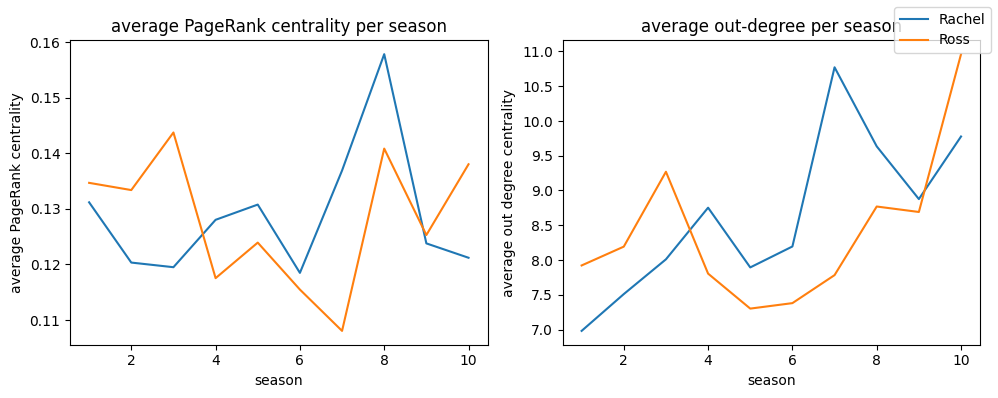

In [365]:
years = np.arange(1,11,1)
fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].set_title('average PageRank centrality per season')
ax[1].set_title('average out-degree per season')

ax[0].plot(years, pr_rachel, label = 'Rachel')
ax[0].plot(years, pr_ross, label = 'Ross')
ax[0].set_xlabel('season')
ax[0].set_ylabel('average PageRank centrality')
ax[1].plot(years, out_rachel)
ax[1].plot(years, out_ross)
ax[1].set_xlabel('season')
ax[1].set_ylabel('average out degree centrality')


# to add the confidence intervals: 
#mean_out_rachel = exam1_rachel['out'].mean()
#scale_out_rachel = stats.sem(exam1_rachel['out'], nan_policy='omit')
#mean_out_ross = exam1_rachel['out'].mean()
#scale_out_ross = stats.sem(exam1_ross['out'], nan_policy='omit')
#mean_pr_rachel = exam1_rachel['pr'].mean()
#scale_pr_rachel = stats.sem(exam1_rachel['pr'], nan_policy='omit')
#mean_pr_ross = exam1_rachel['pr'].mean()
#scale_pr_ross = stats.sem(exam1_ross['pr'], nan_policy='omit')


#ax[1].errorbar(x = years, y = mean_out_rachel, yerr = 1.96*scale_out_rachel, color = 'blue',capsize=5)
#ax[1].errorbar(x = years, y = mean_out_ross, yerr = 1.96*scale_out_ross, color = 'orange',capsize=5)

#ax[0].errorbar(x = years, y = mean_pr_rachel, yerr = 1.96*scale_pr_rachel, color = 'blue',capsize=5)
#ax[0].errorbar(x = years, y = mean_pr_ross, yerr = 1.96*scale_pr_ross, color = 'orange',capsize=5)


fig.legend()
fig.tight_layout()
plt.show()

Here we can see that the plot support the fact that rachel is the show protagonist. But we should look at the CI, if the CI are overlapping, the difference is not statistically significant but if they are not overlapping, the difference is statistically significant. 

However, the difference seems to not be huge between Rachel and Ross 

---

**1.7 —** **/True or false:/** Considering your answer in **1.6** are the following statements true or false? Justify your answer. 


A. "In season 7, Rachel Green's episode-level PageRank and out-degree centrality are higher than Ross Geller's. This difference is statistically significant at the 0.05 significance level."

B. "Phoebe Buffay's out-degree grew between season 1 and season 10; this implies that other characters spoke less than her in season 10."

C. "Phoebe Buffay's PageRank was higher in season 10 than in season 1. This difference is statistically significant at the 0.05 significance level and suggests that the character gained importance over the course of the show."


#A : True, the rachel curves are higher than the ross curves but to see if the differerence is statistically significant at the 0.05 level, we should examine if the CI are overlapping 

#B : False, it means she speak more to other character in the season 10 but does not say anything about how much peoples were speaking 

#C: False ????

In [366]:
t, pvalue = stats.ttest_ind(1, 5)

c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\scipy\stats\_stats_py.py:7030: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


## Part 2: The one about text similarity (40 pts)

Next, you investigate how unique characters are by analyzing what they said throughout the 10 seasons.

**2.1 —** Load the dataframe `exam3.jsonl`. This dataframe is similar to `exam1.jsonl`, except:

- It has an additional column called `tokens`, containing a sentence list. Each sentence is another list composed of tokens, e.g.,
`[['There', "'s", 'nothing', 'to', 'tell', '!'], ['He', "'s", 'just', 'some', 'guy', 'I', 'work', 'with', '!']]`.
- It has an additional column called `episode` containing a unique episode identifier.
- It only contains utterances by Phoebe, Rachel, Ross, Joey, Monica, or Chandler (the main characters).
 
Given this dataframe, you will create an episode-level word-frequency matrix for Chandler Bing, one of the main characters.


In [367]:
df2 = pd.read_json(path_exam3, lines = True)
df2.head()

,id,conversation_id,text,speaker,reply-to,tokens,episode
0,s01_e01_c01_u001,s01_e01_c01_u001,There's nothing to tell! He's just some guy I ...,Monica Geller,None,"[[there, 's, nothing, to, tell, !], [he, 's, j...",s01_e01
1,s01_e01_c01_u002,s01_e01_c01_u001,"C'mon, you're going out with the guy! There's ...",Joey Tribbiani,s01_e01_c01_u001,"[[c'mon, ,, you, 're, going, out, with, the, g...",s01_e01
2,s01_e01_c01_u003,s01_e01_c01_u001,"All right Joey, be nice. So does he have a hum...",Chandler Bing,s01_e01_c01_u002,"[[all, right, joey, ,, be, nice, .], [so, does...",s01_e01
3,s01_e01_c01_u004,s01_e01_c01_u001,"Wait, does he eat chalk?",Phoebe Buffay,s01_e01_c01_u003,"[[wait, ,, does, he, eat, chalk, ?]]",s01_e01
4,s01_e01_c01_u006,s01_e01_c01_u001,"Just, 'cause, I don't want her to go through w...",Phoebe Buffay,s01_e01_c01_u005,"[[just, ,, ', cause, ,, i, do, n't, want, her,...",s01_e01



A. Create a list $L$ containing all distinct tokens uttered by Chandler Bing throughout the 10 seasons, sorted in ascending order. Print the 10 first and last elements of the list. 


In [368]:
# A 
tempA = df2[df2['speaker'] == 'Chandler Bing']['tokens'].values

li = []
for te in tempA:
        for t in te:
            for p in t: 
                li.append(p) 


L = []
for i in li: 
     if i not in L:
          L.append(i)

L = sorted(L)

print('all distinct tokens uttered by Chandler Bing throughout the 10 seasons sorted in ascending order', L)

all distinct tokens uttered by Chandler Bing throughout the 10 seasons sorted in ascending order ['!', '!!', '!!!', '!!!!', '!!!!!', '!!!!!!!', '!..', '!...', '!?', '"', '$', '%', '&', "'", "'75", "'76", "'77", "'79", "'cause", "'d", "'joincidence", "'know", "'ll", "'m", "'re", "'s", "'s-", "'ve", '(', ')', '*', ',', '-', '--', '.', '..', '...', '...!', '...!?', '....', '.....', '......', '.......', '........', '...?', '...?!', '..?', '/', '0.', '007', '1', '1,000', '1,500', '10', '10-100', '100', '101', '11:30', '12', '1200', '128', '130', '15', '16', '17', "1800's", "1890's", '18th', '19', '1965', '1979', '1982', '1986', '1a', '2', '20', '200', '2003', '2020', '21', '2300', '25', '253', '25j', '28', '28,000', '29', '2:00', '2:15', '2:30', '3', '30', '300', '31', '32', '34', '3:30', '4', '4-6', '40', '400', '401', '45', '46', '47', '48', '4:00', '5', '5,000', '50', "50's", '500', '5:00', '6', '62', '69.95', '6:00', '6:30', '7', '7.', '700', '7143457', '79', '7:15', '8', '8,000', '8.',


B. Create a matrix $X$ with $m$ rows and $n$ columns, where: $n$ is the number of tokens in the list $L$ that you just created, and $m$ is the number of episodes (236). Each position $X_{i,j}$ in this matrix should contain the number of times the character uttered the word $j$ in episode $i$. Print how many times Chandler uttered the token `joey` in the first episode of the first season, as well as the shape of the matrix $X$.


In [369]:
m = 236
n = len(L)
B = np.zeros((m, n))
print(B.shape)

for i in range(m):
    for j in range(n):
        B[i,j] = TfidfVectorizer(li)

(236, 6063)


TypeError: __init__() takes 1 positional argument but 2 were given


C. Transform the matrix $X$ into a TF-IDF matrix $T$, combining the following formula (as seen in class):

$$\text{TF}(i,j) = \text{number of times the $j$-th word occurs in the $i$-th episode}$$

$$\text{IDF}(j) =  \log \frac{\text{number of episodes}}{\text{number of episodes in which the $j$-th word occurs}}$$

Print the value in the TF-IDF matrix corresponding to Chandler's utterance of the token `joey` in the first episode of the first season.



D. **/Discuss:/** Some of the tokens (e.g., `joey`) reference other characters. How may these tokens help a classifier predict which character uttered a sentence?

The classifier can know that a character is not going to pronounce its name, so it can know that if it wants to find out who pronounced joey, there is a very small chance that it will be joey, which helps it to predict which character will pronounce a given sentence.

---
For the remainder of the task, you will use the TF-IDF matrix that we compute below. Note:
- This matrix was calculated in a slightly different way: it considers only the 1000 tokens with the highest term frequency.
- We provide three useful variables below (`X`, `y`, and `df_tfidf`). 
    - `X` is a matrix containing the TF-IDF values for the top 1000 tokens, where each row corresponds to a character in an episode. 
    - `y` indicates which character is responsible for the utterance. Each character has a corresponding number, e.g., 2 for Monica Geller; see dictionary below. 
    - `df_tfidf` is a dataframe combining `X` with other episode and utterance-level metadata.

In [370]:
from sklearn.feature_extraction.text import TfidfVectorizer
df_tfidf = pd.read_json("./data/exam3.jsonl", lines=True)[["speaker", "episode", "text"]]

vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
X = vectorizer.fit_transform(df_tfidf.text).toarray()
print("X shape", X.shape)


map_char_to_int = {
'Chandler Bing': 0,
'Joey Tribbiani': 1,
'Monica Geller': 2,
'Phoebe Buffay': 3,
'Rachel Green': 4,
'Ross Geller': 5
}


y = df_tfidf.speaker.apply(lambda x: map_char_to_int[x]).values
print("y shape", y.shape)

df_tfidf = pd.concat([df_tfidf[["speaker", "episode"]],  pd.DataFrame(X)], axis=1)

df_tfidf.head(3)

X shape (51312, 1000)
y shape (51312,)


,speaker,episode,0,1,2,3,4,5,6,7,...,990,991,992,993,994,995,996,997,998,999
0,Monica Geller,s01_e01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Joey Tribbiani,s01_e01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Chandler Bing,s01_e01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


--- 

**2.2 —** To compare characters, carry out a classification task. Train a decision tree classifier to predict which main character uttered a sentence..

A. Split the dataset into training and test sets using sklearn `sklearn.model_selection.train_test_split` using parameters `test_size=0.3` and `random_state=42`, and using the default values for all other parameters.


In [371]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


B. Train a decision tree classifier (`sklearn.tree.DecisionTreeClassifier`) using `random_state=42`, leaving all other parameters as their default.


In [372]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state = 42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)


C. Compute the accuracy of your classifier and of a random baseline, i.e., a classifier that predicts a character uniformly at random. **/Discuss:/** Compare the two accuracies.



In [373]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X, y)

DummyClassifier(strategy='uniform')

In [374]:
y_pred = clf.predict(X_test)
y_pred_random = dummy_clf.predict(X_test)
print('accuracy of the classifier: ', np.mean(y_pred == y_test) * 100, '%')
print('accuray of a random classifier: ', np.mean(y_pred_random == y_test) * 100, '%')

accuracy of the classifier:  23.833961283616993 %
accuray of a random classifier:  16.70131219955827 %


here the accuracy are not really good but we can still see that our classifier performs better than the uniform baseline classifier


D. Compute the confusion matrix of your classifier using `sklearn.metrics.confusion_matrix`. Normalize the confusion matrix such that all cells sum to 1.


In [375]:
print('confusion matrix of my classifier: \n \n', confusion_matrix(y_test, y_pred))
norm = np.linalg.norm(confusion_matrix(y_test, y_pred))
confusion_matrix_normalized = confusion_matrix(y_test, y_pred) / norm
print('\n normalized confusion matrix of my classifier: \n \n' , confusion_matrix_normalized)

confusion matrix of my classifier: 
 
 [[559 394 640 242 381 410]
 [388 586 499 277 368 396]
 [391 304 812 256 414 349]
 [322 313 491 413 370 330]
 [411 332 600 302 691 411]
 [433 410 610 276 405 608]]

 normalized confusion matrix of my classifier: 
 
 [[0.20835834 0.14685722 0.2385498  0.09020164 0.14201168 0.15282097]
 [0.14462082 0.21842216 0.1859943  0.10324734 0.13716614 0.14760269]
 [0.14573902 0.11331116 0.30266006 0.09541992 0.1543119  0.13008419]
 [0.12002037 0.11666576 0.18301243 0.15393917 0.1379116  0.12300224]
 [0.1531937  0.12374771 0.22364044 0.11256569 0.25755924 0.1531937 ]
 [0.16139385 0.15282097 0.22736778 0.1028746  0.1509573  0.22662231]]



E. Plot an appropriate graphical representation of the confusion matrix.


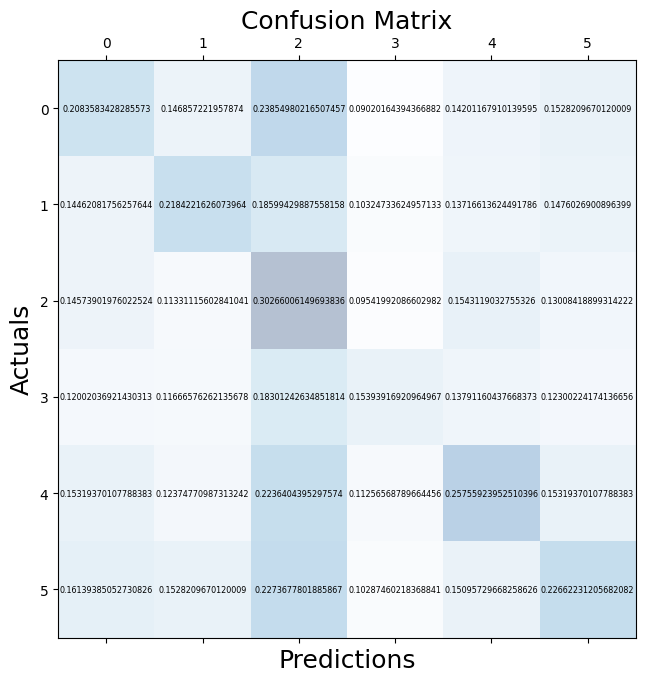

In [376]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(confusion_matrix_normalized, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix_normalized.shape[0]):
    for j in range(confusion_matrix_normalized.shape[1]):
        ax.text(x=j, y=i,s=confusion_matrix_normalized[i, j], va='center', ha='center', size='xx-small')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

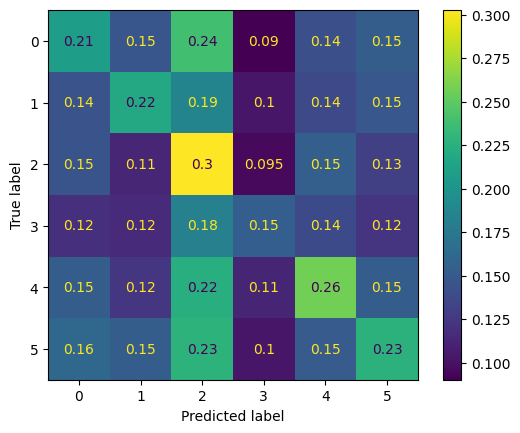

In [377]:
from sklearn import metrics
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_normalized)

cm_display.plot()
plt.show() 


F. **/Discuss:/** Analyzing the confusion matrix, discuss:
   - Which character is most distinct in the way they talk?
   - Which two characters are the most similar in the way they talk?
   - Which two characters are the least similar in the way they talk?


In [378]:
map_char_to_int = {
'Chandler Bing': 0,
'Joey Tribbiani': 1,
'Monica Geller': 2,
'Phoebe Buffay': 3,
'Rachel Green': 4,
'Ross Geller': 5
}

character 2, Monica Geller is the most distinct in the way she talk (look at the diagonal)

to find which two characters are the most similar in the way they talk we need to not look at the 
diagonal but to look at the pair (i,j) and (j,i)
if (i,j) and (j,i) scores high --> similar characters
characters 2 and 0, Chandler Bing and Monica Geller are the most similar characters 

characters 0 and 3, Chandler Bing and Phoebe Buffay are the least similar in the way they talk 


---

**2.3 —** **/Discuss:/** Last, you discuss the results obtained in **2.2** with a friend, who asks you some thought-provoking questions.

A. Your friend proposes that you should create a measure of similarity between two characters in a given episode in a more direct way than what you've done in **2.2**.  Propose (but do not implement) said similarity metric.

B. Your friend also suggests that your analysis might not truly capture how two characters differ. According to her, if people are in the same conversation, they might speak similarly simply because they are in the same social context. Propose (but do not implement) a way of creating a dataset where this confounder does not exist.

C. Last, your friend complains about how you present your (normalized) confusion matrix. According to her, from reading the cells alone, it is unclear if the fraction of occurrences is higher or lower than what a random classifier would yield. Propose (but do not implement) a way of modifying the confusion matrix to address her concern.


we would need to have a data set of each character, train them on the whole set and then test them on each character independently. If the score is high in both directions (i for j and j for i), then this means that they speak in the "same way" and are therefore similar.

We need to remove the capture of the semantic around a world, we need to put in place an algorithm that doesn't capture the semantic, not the meaning of the words but just the words to remove this confounder.

we could set up a threshold system, in fact we take the accuracy on the random classifier test set as the threshold value and then in the confusion matrix display, we display the cell in red if the value is greater than the threshold and otherwise we display the cell in blue.

---